In [1]:
!pip install torch==2.7.0
!pip install torch-geometric
!pip install biopython
!pip install obonet
!pip install networkx
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install fair-esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 841.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cusparselt-cu12
    Found existing installation: nvidia-cusparselt-cu12 0.7.1
    Uninstalling nvidia-cusparselt-cu12-0.7.1:
      Successfully uninstalled nvidia-cusparselt-cu12-0.7.1
  Attempting uninstall: triton
    Found existing installation: triton 3.4.0
    Uninstalling triton-3.4.0:
      Successfully uninstalled triton-3.4.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.27.3
    Uninstalling nvidia-nccl-cu12-2.27.3:
      Successfully uninstalled nvidia-nccl-cu12-2.27.3
  Attempting uninstall: nvidia-cudnn

In [1]:
import os
import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import Bio
from Bio import SeqIO
import obonet
import gc
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import esm


In [2]:
obo_path = '/content/go-basic.obo'
fasta_path = '/content/train_sequences.fasta'
term_path = '/content/train_terms.tsv'

In [3]:
graph = obonet.read_obo(obo_path)


nodes = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')
nodes.reset_index(inplace=True)
nodes.rename(columns={'index': 'id'}, inplace=True)

edges = pd.DataFrame([
    {'source': u, 'target': v, 'relation': data.get('relation', 'is_a')}
    for u, v, data in graph.edges(data=True)
])

print("Number of nodes:", len(nodes))
print("Number of edges:", len(edges))

print("\nSample nodes:")
print(nodes.head())

print("\nSample edges:")
print(edges.head())

Number of nodes: 40122
Number of edges: 77229

Sample nodes:
           id                                               name  \
0  GO:0000001                          mitochondrion inheritance   
1  GO:0000002                   mitochondrial genome maintenance   
2  GO:0000006  high-affinity zinc transmembrane transporter a...   
3  GO:0000007  low-affinity zinc ion transmembrane transporte...   
4  GO:0000009             alpha-1,6-mannosyltransferase activity   

            namespace                                                def  \
0  biological_process  "The distribution of mitochondria, including t...   
1  biological_process  "The maintenance of the structure and integrit...   
2  molecular_function  "Enables the transfer of zinc ions (Zn2+) from...   
3  molecular_function  "Enables the transfer of a solute or solutes f...   
4  molecular_function  "Catalysis of the transfer of a mannose residu...   

                                             synonym  \
0             ["m

### Visualize the GO graph for 1% sampled edges

Loaded 40122 nodes and 77229 edges
Sampled 77 edges
Subgraph has 154 nodes and 77 edges


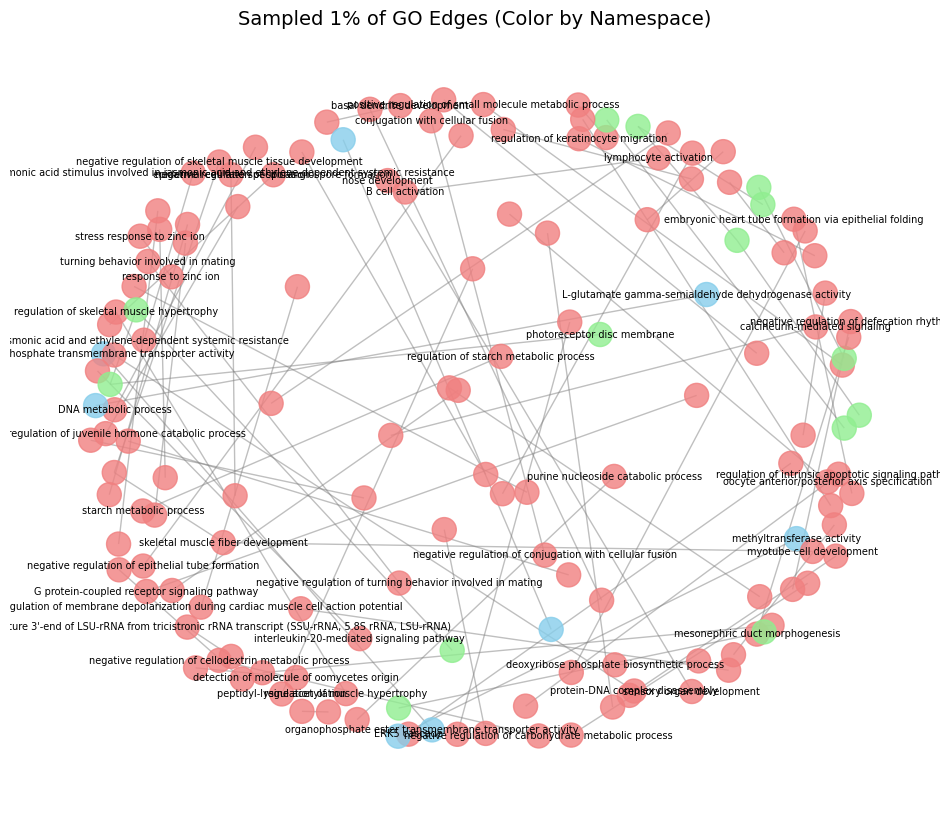

In [4]:

nodes = pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index').reset_index()
nodes.rename(columns={'index': 'id'}, inplace=True)

edges = pd.DataFrame([
    {'source': u, 'target': v, 'relation': data.get('relation', 'is_a')}
    for u, v, data in graph.edges(data=True)
])

print(f"Loaded {len(nodes)} nodes and {len(edges)} edges")

# ------------------------------
# Step 3: Sample 1% of edges
# ------------------------------
sampled_edges = edges.sample(frac=0.001, random_state=42).reset_index(drop=True)
print(f"Sampled {len(sampled_edges)} edges")


sampled_node_ids = set(sampled_edges['source']).union(set(sampled_edges['target']))
sampled_nodes = nodes[nodes['id'].isin(sampled_node_ids)]

print(f"Subgraph has {len(sampled_nodes)} nodes and {len(sampled_edges)} edges")


subgraph = graph.subgraph(sampled_node_ids).copy()


plt.figure(figsize=(12, 10))

pos = nx.spring_layout(subgraph, k=0.8, seed=42)


namespace_colors = {
    'biological_process': 'lightcoral',
    'molecular_function': 'skyblue',
    'cellular_component': 'lightgreen'
}
node_colors = [
    namespace_colors.get(subgraph.nodes[n].get('namespace', ''), 'gray')
    for n in subgraph.nodes()
]


nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=300, alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, arrows=False, edge_color='gray', alpha=0.5)


label_nodes = dict(list(subgraph.nodes(data=True))[:50])
nx.draw_networkx_labels(
    subgraph,
    pos,
    labels={n: d.get('name', n) for n, d in label_nodes.items()},
    font_size=7
)

plt.title("Sampled 1% of GO Edges (Color by Namespace)", fontsize=14)
plt.axis('off')
plt.show()


### Create set of embedding from the graph edges using GCN

In [5]:
# ---------------------------------------------------
# Read TSV and Sample by EntryID
# ---------------------------------------------------
def sample_tsv(file_path, sample_frac=0.05, random_state=42):
    """
    Read a TSV file and sample based on unique EntryID.
    Pulls in all associated rows for sampled EntryIDs.
    """
    df = pd.read_csv(file_path, sep='\t')
    unique_ids = df['EntryID'].unique()
    sample_size = max(1, int(len(unique_ids) * sample_frac))
    sampled_ids = random.sample(list(unique_ids), sample_size)
    sampled_df = df[df['EntryID'].isin(sampled_ids)]
    print(f"Sampled {len(sampled_df)} rows from {len(unique_ids)} unique EntryIDs")
    return sampled_df


In [6]:
def create_go_embeddings_optimized(obo_path, go_terms, embed_dim=16, hidden_dim=32, out_dim=16, epochs=50):

    print(" Loading Gene Ontology...")
    graph = obonet.read_obo(obo_path)


    edges = pd.DataFrame([
        {'source': u, 'target': v, 'relation': data.get('relation', 'is_a')}
        for u, v, data in graph.edges(data=True)
    ])

    relevant_edges = edges[
        edges['source'].isin(go_terms) | edges['target'].isin(go_terms)
    ].reset_index(drop=True)

    nodes = pd.DataFrame({'id': list(set(relevant_edges['source']).union(relevant_edges['target']))})
    nodes['node_idx'] = range(len(nodes))
    node2idx = dict(zip(nodes['id'], nodes['node_idx']))

    edge_index = torch.tensor([
        [node2idx[s] for s in relevant_edges['source']],
        [node2idx[t] for t in relevant_edges['target']]
    ], dtype=torch.long)

    num_nodes = len(nodes)
    print(f"Using {num_nodes} GO terms and {len(relevant_edges)} edges")


    x = torch.randn((num_nodes, embed_dim), dtype=torch.float32)


    class SimpleGCN(nn.Module):
        def __init__(self, in_dim, hidden_dim, out_dim):
            super(SimpleGCN, self).__init__()
            self.conv1 = GCNConv(in_dim, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, out_dim)

        def forward(self, x, edge_index):
            x = self.conv1(x, edge_index)
            x = F.relu(x)
            x = self.conv2(x, edge_index)
            return x

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleGCN(embed_dim, hidden_dim, out_dim).to(device)


    x = x.to(device)
    edge_index = edge_index.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    data = Data(x=x, edge_index=edge_index)

    print(f"Training on device: {device}")
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        embeddings = model(data.x, data.edge_index)
        # Inner product decoder
        recon = torch.sigmoid(torch.matmul(embeddings, embeddings.T))
        adj_true = torch.zeros_like(recon)
        adj_true[data.edge_index[0], data.edge_index[1]] = 1.0

        loss = F.binary_cross_entropy(recon, adj_true)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")


    with torch.no_grad():
        node_embeddings = model(data.x, data.edge_index).cpu().numpy()

    del model, x, data, recon, adj_true
    torch.cuda.empty_cache()
    gc.collect()

    col_names = [f"go_emb_{i}" for i in range(node_embeddings.shape[1])]

    emb_df = pd.DataFrame(node_embeddings, index=nodes['id'], columns=col_names)
    print(f"Created embeddings for {len(emb_df)} GO terms")
    return emb_df





In [7]:
# ---------------------------------------------------
# Pull protein sequences from FASTA file
# ---------------------------------------------------
def extract_sequences(fasta_path, entry_ids):
    records = []
    entry_ids = set(entry_ids)
    for record in SeqIO.parse(fasta_path, "fasta"):
        # Typical Uniprot headers: ">sp|P12345|PROT_HUMAN ..."
        label = record.id.split('|')[1] if '|' in record.id else record.id
        if label in entry_ids:
            records.append({
                'EntryID': label,
                'Sequence': str(record.seq)
            })
    seq_df = pd.DataFrame(records)
    print(f"Retrieved {len(seq_df)} sequences matching EntryIDs")
    return seq_df



### Sample 0.5% of the data and create embedding based on that

In [8]:
sampled_data = sample_tsv(term_path, sample_frac=0.05)
go_terms = sampled_data['term'].unique()
embeddings_df = create_go_embeddings_optimized(obo_path, go_terms)
seq_df = extract_sequences(fasta_path, sampled_data['EntryID'])

Sampled 26355 rows from 82404 unique EntryIDs
 Loading Gene Ontology...
Using 26467 GO terms and 36544 edges
Training on device: cuda
Epoch 000 | Loss: 2.2476
Epoch 010 | Loss: 0.8493
Epoch 020 | Loss: 0.7610
Epoch 030 | Loss: 0.7156
Epoch 040 | Loss: 0.7098
Epoch 049 | Loss: 0.7023
Created embeddings for 26467 GO terms
Retrieved 4120 sequences matching EntryIDs


In [9]:
torch.cuda.empty_cache()

### Create embedding using Protein Language Model

In [10]:
def generate_protein_embeddings_esm_optimized(seq_df, seq_col='Sequence', entryid_col='EntryID',
                                              target_dim=16, batch_size=1, use_fp16=True):
    """
    Memory-optimized ESM embedding generation for proteins.
    Processes small batches and moves embeddings to CPU immediately.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Load pretrained ESM model
    # model, alphabet = esm.pretrained.esm2_t30_150M_UR50D()
    model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
    model = model.to(device)
    model.eval()

    batch_converter = alphabet.get_batch_converter()

    sequences = seq_df[seq_col].tolist()
    entry_ids = seq_df[entryid_col].tolist()

    all_embeddings = []

    for i in range(0, len(sequences), batch_size):
        batch_seqs = sequences[i:i+batch_size]
        batch_labels = entry_ids[i:i+batch_size]

        batch_data = [(label, seq) for label, seq in zip(batch_labels, batch_seqs)]
        _, _, batch_tokens = batch_converter(batch_data)
        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[model.num_layers], return_contacts=False)
            token_embeddings = results["representations"][model.num_layers]  # (B, L, D)

            # Mean pool over sequence length
            attention_mask = batch_tokens != alphabet.padding_idx
            masked_embeddings = token_embeddings * attention_mask.unsqueeze(-1)
            seq_lengths = attention_mask.sum(dim=1).unsqueeze(-1)
            seq_embeddings = (masked_embeddings.sum(dim=1) / seq_lengths).cpu().float().numpy()

        all_embeddings.append(seq_embeddings)
        del batch_tokens, token_embeddings, masked_embeddings, seq_embeddings
        torch.cuda.empty_cache()

    raw_embeddings = np.vstack(all_embeddings)
    print("Raw embeddings shape:", raw_embeddings.shape)

    if raw_embeddings.shape[1] > target_dim:
        pca = PCA(n_components=target_dim)
        reduced = pca.fit_transform(raw_embeddings)
    else:
        reduced = np.zeros((raw_embeddings.shape[0], target_dim), dtype=np.float32)
        reduced[:, :raw_embeddings.shape[1]] = raw_embeddings

    col_names = [f"prot_emb_{i}" for i in range(target_dim)]
    emb_df = pd.DataFrame(reduced, index=entry_ids, columns=col_names)
    emb_df.index.name = entryid_col
    print("Reduced embeddings shape:", emb_df.shape)
    return emb_df


prot_emb_df = generate_protein_embeddings_esm_optimized(seq_df, seq_col='Sequence', entryid_col='EntryID', target_dim=16)

# Merge with sampled_data if needed
merged = sampled_data.merge(prot_emb_df, how='left', left_on='EntryID', right_index=True)
print(merged.head())


Using device: cuda
Raw embeddings shape: (4120, 320)
Reduced embeddings shape: (4120, 16)
    EntryID        term aspect  prot_emb_0  prot_emb_1  prot_emb_2  \
83   Q8IN81  GO:0005515      F   -0.429557   -1.297921   -0.152282   
87   P40750  GO:0005515      F    2.110071    0.630770   -0.703839   
153  Q5XJA3  GO:0005737      C   -0.774279   -0.491650   -0.393995   
154  Q5XJA3  GO:0005794      C   -0.774279   -0.491650   -0.393995   
155  Q5XJA3  GO:0034237      F   -0.774279   -0.491650   -0.393995   

     prot_emb_3  prot_emb_4  prot_emb_5  prot_emb_6  prot_emb_7  prot_emb_8  \
83     0.276579   -0.447162    0.248742    0.773700   -0.562212    0.205444   
87    -0.300600   -0.214405   -0.105722   -0.053853    0.195367    0.251252   
153    0.793564   -0.502398    0.336615    0.475678    0.349370    0.304352   
154    0.793564   -0.502398    0.336615    0.475678    0.349370    0.304352   
155    0.793564   -0.502398    0.336615    0.475678    0.349370    0.304352   

     prot_emb_

### Combine GO embedding and PLM embedding into one dataset

In [11]:
def combine_go_protein_embeddings(sampled_data, go_emb_df, prot_emb_df):

    combined = sampled_data.merge(go_emb_df, how='left', left_on='term', right_index=True)

    combined = combined.merge(prot_emb_df, how='left', left_on='EntryID', right_index=True)

    return combined


multimodal_df = combine_go_protein_embeddings(sampled_data, embeddings_df, prot_emb_df)

print("Multimodal feature dataframe shape:", multimodal_df.shape)
print(multimodal_df.head())

Multimodal feature dataframe shape: (26355, 35)
    EntryID        term aspect  go_emb_0  go_emb_1  go_emb_2  go_emb_3  \
83   Q8IN81  GO:0005515      F -0.297623  0.398860 -0.334755  0.260366   
87   P40750  GO:0005515      F -0.297623  0.398860 -0.334755  0.260366   
153  Q5XJA3  GO:0005737      C -0.325007  0.503157  0.170633 -0.105559   
154  Q5XJA3  GO:0005794      C -0.136103  0.221921 -0.409287  0.133370   
155  Q5XJA3  GO:0034237      F -0.044683  0.038582 -0.364278  0.002474   

     go_emb_4  go_emb_5  go_emb_6  ...  prot_emb_6  prot_emb_7  prot_emb_8  \
83  -0.220670 -0.337681 -0.039133  ...    0.773700   -0.562212    0.205444   
87  -0.220670 -0.337681 -0.039133  ...   -0.053853    0.195367    0.251252   
153 -0.384995 -0.531075  0.740250  ...    0.475678    0.349370    0.304352   
154  0.371617 -0.099497 -0.022758  ...    0.475678    0.349370    0.304352   
155  0.528963  0.162767  0.262254  ...    0.475678    0.349370    0.304352   

     prot_emb_9  prot_emb_10  prot_emb

### Create a simple NN model for baseline

In [12]:
feature_cols = [col for col in multimodal_df.columns if col.startswith('prot_emb_')]

# If we are using GO embedding as well
# feature_cols = [col for col in multimodal_df.columns if col.startswith('go_emb_') or col.startswith('prot_emb_')]
X = multimodal_df[feature_cols].values
# multimodal_df['label'] = multimodal_df['term'] + '_' + multimodal_df['aspect']
multimodal_df['label'] = multimodal_df['term']
y = multimodal_df['label'].values


le = LabelEncoder()
y_encoded = le.fit_transform(y)


X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)


X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [13]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]
hidden_dim = 64
num_classes = len(le.classes_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN(input_dim, hidden_dim, num_classes).to(device)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30

train_losses = []
val_losses = []
train_accs = []
val_accs = []


In [15]:
for epoch in range(num_epochs):
    # ------------------ Training ------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # ------------------ Validation ------------------
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_loss / total)
    val_accs.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]:.4f} | "
          f"Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]:.4f}")


Epoch 1/30 | Train Loss: 8.0818, Acc: 0.0580 | Val Loss: 7.8379, Acc: 0.0628
Epoch 2/30 | Train Loss: 6.9374, Acc: 0.0640 | Val Loss: 8.0836, Acc: 0.0656
Epoch 3/30 | Train Loss: 6.5272, Acc: 0.0649 | Val Loss: 8.4165, Acc: 0.0668
Epoch 4/30 | Train Loss: 6.2120, Acc: 0.0646 | Val Loss: 8.7968, Acc: 0.0658
Epoch 5/30 | Train Loss: 5.9159, Acc: 0.0665 | Val Loss: 9.2805, Acc: 0.0658
Epoch 6/30 | Train Loss: 5.6199, Acc: 0.0678 | Val Loss: 9.8010, Acc: 0.0618
Epoch 7/30 | Train Loss: 5.3327, Acc: 0.0683 | Val Loss: 10.3989, Acc: 0.0611
Epoch 8/30 | Train Loss: 5.0737, Acc: 0.0704 | Val Loss: 10.9957, Acc: 0.0562
Epoch 9/30 | Train Loss: 4.8609, Acc: 0.0750 | Val Loss: 11.5528, Acc: 0.0527
Epoch 10/30 | Train Loss: 4.6941, Acc: 0.0779 | Val Loss: 12.0424, Acc: 0.0488
Epoch 11/30 | Train Loss: 4.5666, Acc: 0.0815 | Val Loss: 12.4707, Acc: 0.0417
Epoch 12/30 | Train Loss: 4.4654, Acc: 0.0875 | Val Loss: 12.8579, Acc: 0.0404
Epoch 13/30 | Train Loss: 4.3833, Acc: 0.0871 | Val Loss: 13.1745, 

### Loss and Accuracy evaluation

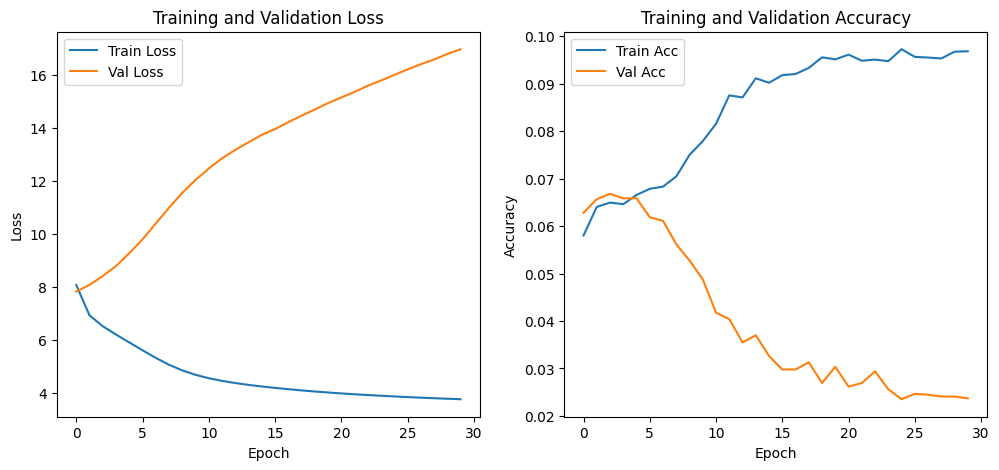

In [16]:
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [ ]:

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

import seaborn as sns
import numpy as np


class_labels = le.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
